In [23]:
import caiman as cm
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from matplotlib import pyplot as plt
import numpy as np
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.mmapping import save_memmap
from scipy.sparse import csc_matrix
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import os
from scipy.io import savemat

#start parallel processing, should just make things faster

###STARTS CLUSTERS 
        #%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


In [25]:
#paths to the h5 files
# fileList = ['/mnt/Brenna_Feb2023/TdTG7_19/20230327/gui/caimanOuputs_2023_4_2_16_1/ConcatenatedMovie_MC_reg_caimanEval_Python.hdf5', 
# '/mnt/Brenna_Feb2023/TdTG7_19/20230327/track_beforegain/caimanOuputs_2023_4_2_18_9/ConcatenatedMovie_MC_reg_caimanEval_Python.hdf5']

fileList = ['/mnt/lily_shared/tdt_210/250330/gui_rec001/caimanOuputs_2025_3_31_19_47/ConcatenatedMovie_MC_caimanEval_Python.hdf5',
            '/mnt/lily_shared/tdt_210/250330/1w_rec002/caimanOuputs_2025_3_31_19_30/ConcatenatedMovie_MC_caimanEval_Python.hdf5']
fileListAddCorr = []

sessionList = []
for file in fileList:
    # currentEstimate = load_CNMF(file)
    # sessionList.append(currentEstimate)
    pass

#paths to the movies
# imageFileList = ['/mnt/Brenna_Feb2023/TdTG7_19/20230327/gui/ConcatenatedMovie_MC_reg.tif', 
# '/mnt/Brenna_Feb2023/TdTG7_19/20230327/track_beforegain/ConcatenatedMovie_MC_reg.tif']

imageFileList = ['/mnt/lily_shared/tdt_210/250330/gui_rec001/ConcatenatedMovie_MC.tif',
            '/mnt/lily_shared/tdt_210/250330/1w_rec002/ConcatenatedMovie_MC.tif']

for cF in range(len(imageFileList)):
    currentEstimate = load_CNMF(fileList[cF])
    sessionList.append(currentEstimate)

    file = imageFileList[cF]
    dataDir = os.path.dirname(file)
    fileName = os.path.basename(file)[0:-4]
    print(fileName)
    currentMemMap = save_memmap([file], base_name=fileName + 'mmapFile', order='C')

    #make the correlation image
    Yr, dims, T = cm.load_memmap(currentMemMap)
    images = np.reshape(Yr.T, [T] + list(dims), order='F')
    Cn = cm.local_correlations(images.transpose(1,2,0)) 
    #save it into the caiman object
    currentCNM = sessionList[cF]
    currentCNM.Cn = Cn
    #resave h5 with the correlations image
    currentCNM.save(os.path.join(dataDir, fileName + '_caimanEval_Python_testingRegisterFile.hdf5'))
    # save out the filename for future process
    fileListAddCorr.append(os.path.join(dataDir, fileName + '_caimanEval_Python_testingRegisterFile.hdf5'))
    #should remove the memmapped file once the correlations imagee is made
    os.remove(os.path.join(dataDir ,currentMemMap))

<TiffTag.fromfile> raised TiffFileError('<tifffile.TiffTag 254 @10> invalid value offset 0')
Your tif file is saved a single pagefile. Performance will be affected


ConcatenatedMovie_MC


<TiffTag.fromfile> raised TiffFileError('<tifffile.TiffTag 254 @10> invalid value offset 0')
Your tif file is saved a single pagefile. Performance will be affected


ConcatenatedMovie_MC


In [30]:
os.path.join(dataDir, fileList[cF][0:-5] + '_addLocalCorr.hdf5')

'/mnt/lily_shared/tdt_210/250330/1w_rec002/caimanOuputs_2025_3_31_19_30/ConcatenatedMovie_MC_caimanEval_Python_addLocalCorr.hdf5'

In [18]:
#After your files are memory mapped and the new h5 file with the correlations field is saved you can put the paths to those h5 files in session list and run this cell. 
sessionList = fileListAddCorr
CI = []
spatialComps = []
for cS in sessionList:
    currentSession = load_CNMF(cS)
    CI.append(currentSession.Cn)
    spatialComps.append(currentSession.estimates.A)


A = [csc_matrix(A1/A1.sum(0)) for A1 in spatialComps]

dims = [ci.shape for ci in CI]
dims_comb = tuple(np.array(dims).max(axis=0))

#this is going to do a lot of reshaping and padding because all the videos are not the same size a lot of the time
masks = [np.reshape(A_.toarray(), dims_ + (-1,), order='F').transpose(2, 0, 1)
             for A_, dims_ in zip(A, dims)]
masks = [np.pad(m, list(zip([0]*3,[0, *(np.array(dims_comb) - m.shape[1:])])),
                'constant', constant_values=0) for m in masks]
CI = [np.pad(ci, list(zip([0]*2, (np.array(dims_comb) - ci.shape))),
             'constant', constant_values=0) for ci in CI]

A = [csc_matrix(m.transpose(1,2,0).reshape((-1, m.shape[0]), order='F')) for m in masks]

#max threshold parameter before binarization (not totally sure what this means but seems like it is important)
max_thr = 0.1
#the actual line that does all of the registrations stuff
spatial_union, assignments, matchings = register_multisession(A, dims_comb, CI, max_thr=max_thr)
#This link could be helpful for understanding the outputs: https://caiman.readthedocs.io/en/master/core_functions.html#caiman.base.rois.register_multisession

matInfo = {}
matInfo['spatial_union'] = spatial_union
matInfo['assignments'] = assignments
matInfo['matchings'] = matchings

savemat(os.path.join(dataDir, fileName + '_registration.mat'), matInfo)


/home/howelab/miniforge3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [21]:
os.path.join(dataDir, fileName + 'registration.mat')

'/mnt/lily_shared/tdt_210/250330/1w_rec002/ConcatenatedMovie_MCregistration.mat'

[{'coordinates': array([[         nan,          nan],
         [275.08841542,  18.        ],
         [275.30441729,  17.        ],
         [275.3833934 ,  16.        ],
         [275.42611501,  15.        ],
         [275.52629155,  14.        ],
         [275.41894865,  13.        ],
         [275.        ,  12.26609368],
         [274.69919867,  12.        ],
         [274.        ,  11.30080133],
         [273.        ,  11.30080133],
         [272.        ,  11.46698584],
         [271.        ,  11.75108869],
         [270.75108869,  12.        ],
         [270.        ,  12.75108869],
         [269.76703791,  13.        ],
         [269.        ,  13.79993379],
         [268.88331433,  14.        ],
         [268.47042239,  15.        ],
         [268.47042239,  16.        ],
         [268.54209381,  17.        ],
         [269.        ,  17.90687724],
         [269.04022938,  18.        ],
         [269.56674622,  19.        ],
         [270.        ,  19.77842272],
         [

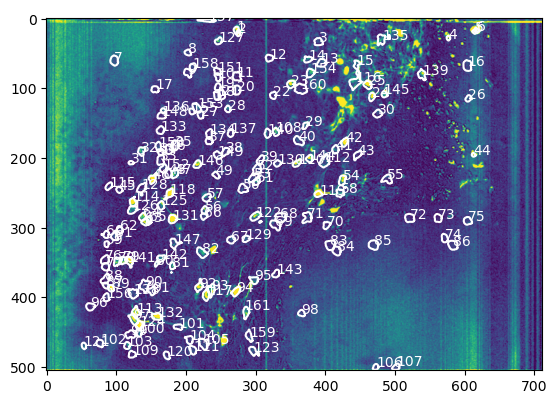

In [19]:
#we can then also filter those outputs and say well we only want ROIs that are active in 5 out of 6 sessions (or in this case 2)

# Filter components by number of sessions the component could be found

n_reg = 2  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int)

# Use filtered indices to select the corresponding spatial components
spatial_filtered = A[0][:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, CI[-1])

In [3]:
len(CI)

NameError: name 'CI' is not defined

In [33]:
#useful functions for plotting an image and the ROIs you want over it
plot = nb_plot_contour(CI[0], spatial_filtered, dims_comb[0], dims_comb[1])

In [41]:
#Load individual caiman sessions (the h5)

# session1= load_CNMF('/mnt/Brenna_Feb2023/TdTG7_19/20230327/gui/ConcatenatedMovie_MC_reg_caimanEval_Python_testingRegisterFile.hdf5')
# session2 = load_CNMF('/mnt/Brenna_Feb2023/TdTG7_19/20230327/track_beforegain/ConcatenatedMovie_MC_reg_caimanEval_Python_testingRegisterFile.hdf5')

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


Preparing data for /mnt/lily_shared/tdt_210/250330/gui_rec001/ConcatenatedMovie_MC.tif


<TiffTag.fromfile> raised TiffFileError('<tifffile.TiffTag 254 @10> invalid value offset 0')
Your tif file is saved a single pagefile. Performance will be affected


Memory map, mem-map file saved at: /home/howelab/caiman_data/temp/ConcatenatedMovie_MCmmapFile_d1_505_d2_712_d3_1_order_C_frames_26152.mmap
Calculating local correlation...
Trying to save file:  /mnt/lily_shared/tdt_210/250330/gui_rec001/caimanOuputs_2025_3_31_19_47/ConcatenatedMovie_MC_caimanEval_Python_addLocalCorr.hdf5
Deleting mem map file at: /home/howelab/caiman_data/temp/ConcatenatedMovie_MCmmapFile_d1_505_d2_712_d3_1_order_C_frames_26152.mmap
Preparing data for /mnt/lily_shared/tdt_210/250330/1w_rec002/ConcatenatedMovie_MC.tif


<TiffTag.fromfile> raised TiffFileError('<tifffile.TiffTag 254 @10> invalid value offset 0')
Your tif file is saved a single pagefile. Performance will be affected


Memory map, mem-map file saved at: /home/howelab/caiman_data/temp/ConcatenatedMovie_MCmmapFile_d1_505_d2_712_d3_1_order_C_frames_38941.mmap
Calculating local correlation...
Trying to save file:  /mnt/lily_shared/tdt_210/250330/1w_rec002/caimanOuputs_2025_3_31_19_30/ConcatenatedMovie_MC_caimanEval_Python_addLocalCorr.hdf5
Deleting mem map file at: /home/howelab/caiman_data/temp/ConcatenatedMovie_MCmmapFile_d1_505_d2_712_d3_1_order_C_frames_38941.mmap


/home/howelab/miniforge3/envs/caiman/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Saving registeration result to: /mnt/lily_shared/tdt_210/250330/1w_rec002/ConcatenatedMovie_MC_registration.mat


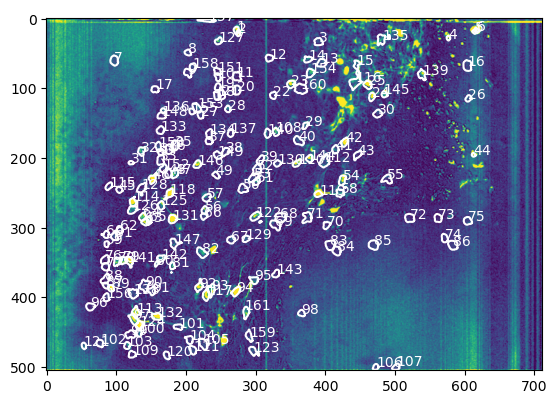

In [1]:
from caimanMutiRegFunction import runMutiReg

cm_fileList = ['/mnt/lily_shared/tdt_210/250330/gui_rec001/caimanOuputs_2025_3_31_19_47/ConcatenatedMovie_MC_caimanEval_Python.hdf5',
            '/mnt/lily_shared/tdt_210/250330/1w_rec002/caimanOuputs_2025_3_31_19_30/ConcatenatedMovie_MC_caimanEval_Python.hdf5']

movie_list = ['/mnt/lily_shared/tdt_210/250330/gui_rec001/ConcatenatedMovie_MC.tif',
            '/mnt/lily_shared/tdt_210/250330/1w_rec002/ConcatenatedMovie_MC.tif']

multiReg = runMutiReg(cm_fileList,movie_list)

In [27]:
# This block is designated to used for generating a list of filelists.
# should follow some format like [[cm_list1],[cm_list2],[cm_list3]...]
# and [[movie_list1],[movie_list2],[movie_list3]...]
import os
movieList = []
skippedList = []
# where we start, will search all nodes down stream of the
# startDir
startDir = '/mnt/lily_shared' #'/mnt/lily_shared2'
# what filename we search for if you used the batch script it should be as below.
pat_gui = 'gui_rec'
pat_gui2 = 'norewgui_rec'
pat_track = '1w_rec' 

sess_list = []
for root,dirnames,filenames in os.walk(startDir):
    gui_dirs = [os.path.join(root,d) for d in dirnames if d.startswith((pat_gui,pat_gui2))]
    track_dirs =[os.path.join(root,d) for d in dirnames if d.startswith(pat_track)]
    if gui_dirs and track_dirs:
        sess_list.append(track_dirs + gui_dirs)

sess_list


[['/mnt/lily_shared/a2a_260/250408/1w_rec002',
  '/mnt/lily_shared/a2a_260/250408/gui_rec001'],
 ['/mnt/lily_shared/a2a_260/250410/1w_rec001',
  '/mnt/lily_shared/a2a_260/250410/gui_rec002'],
 ['/mnt/lily_shared/a2a_262/250404/1w_rec002',
  '/mnt/lily_shared/a2a_262/250404/gui_rec001'],
 ['/mnt/lily_shared/a2a_262/250407/1w_rec001',
  '/mnt/lily_shared/a2a_262/250407/gui_rec002'],
 ['/mnt/lily_shared/a2a_267/250408/1w_rec001',
  '/mnt/lily_shared/a2a_267/250408/gui_rec002'],
 ['/mnt/lily_shared/a2a_267/250410/1w_rec002',
  '/mnt/lily_shared/a2a_267/250410/gui_rec001'],
 ['/mnt/lily_shared/a2a_270/250403/1w_rec002',
  '/mnt/lily_shared/a2a_270/250403/gui_rec001'],
 ['/mnt/lily_shared/a2a_270/250408/1w_rec001',
  '/mnt/lily_shared/a2a_270/250408/gui_rec002'],
 ['/mnt/lily_shared/a2a_270/250410/1w_rec001',
  '/mnt/lily_shared/a2a_270/250410/gui_rec002'],
 ['/mnt/lily_shared/a2a_270/250414/1w_rec001',
  '/mnt/lily_shared/a2a_270/250414/gui_rec002'],
 ['/mnt/lily_shared/tdt_011/250122/1w_re